In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import TimeLLM, NHITS, PatchTST, LSTM
from transformers import GPT2Config, GPT2Model, GPT2Tokenizer
import os
from utilsforecast.plotting import plot_series
from neuralforecast.losses.pytorch import MQLoss
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse, mae, mape, mse

### NHITS

In [33]:
Y_df = pd.read_csv("data/processed/walmart_sales/merged_nf_small.csv")
Y_df["ds"] = pd.to_datetime(Y_df["ds"])
Y_train_df = Y_df[Y_df["ds"] < "2012-01-01"]
Y_test_df = Y_df[Y_df["ds"] >= "2012-01-01"]

models = [
    NHITS(
        h=43,
        input_size=64,
        hist_exog_list=[
            "Type",
            "Size",
            "Year",
            "Month",
            "Week",
            "IsHoliday",
            "MarkDown1",
            "MarkDown2",
            "MarkDown3",
            "Fuel_Price",
        ],
        scaler_type="robust",
        max_steps=200,
    ),
]
nf = NeuralForecast(models=models, freq="W-FRI")

nf.fit(df=Y_train_df)

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.891    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

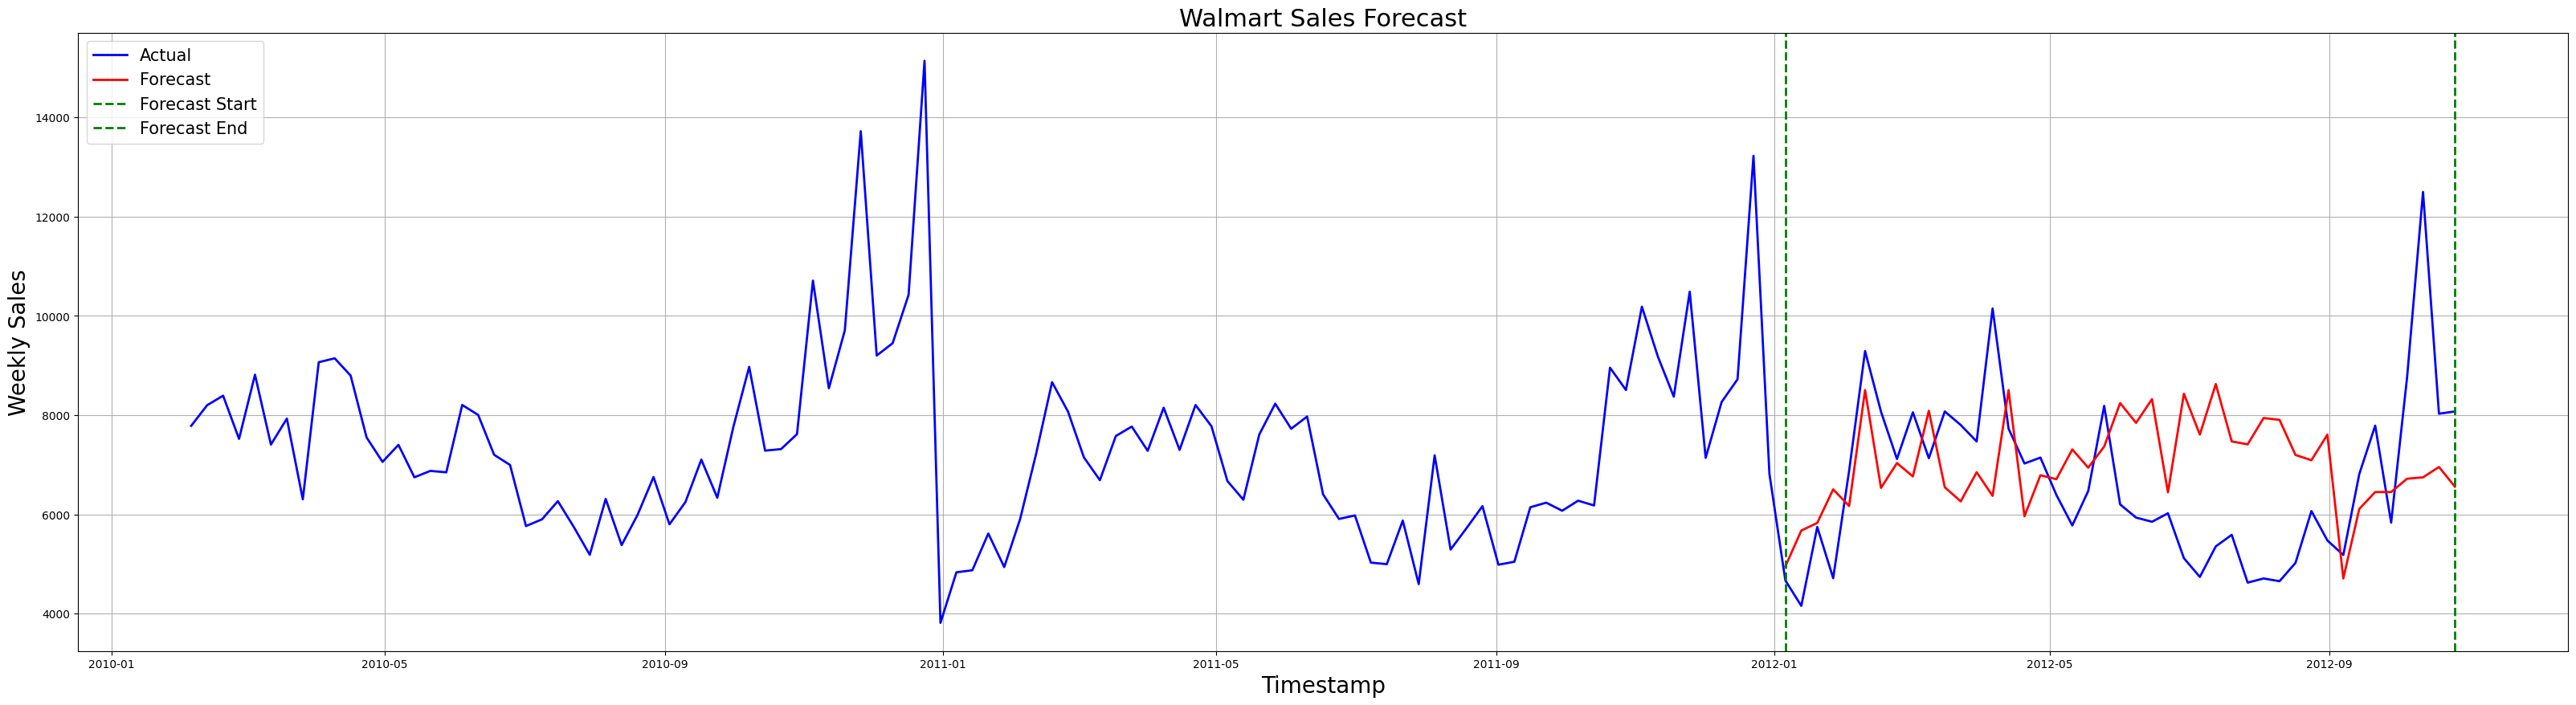

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(40, 10))

Y_hat_df = nf.predict().reset_index()

ax.plot(Y_df["ds"], Y_df["y"], label="Actual", color="blue", linewidth=2)
ax.plot(Y_hat_df["ds"], Y_hat_df["NHITS"], label="Forecast", color="red", linewidth=2)

forecast_start_date = Y_hat_df["ds"].min()
forecast_end_date = Y_hat_df["ds"].max()

ax.axvline(
    x=forecast_start_date,
    color="green",
    linestyle="--",
    linewidth=2,
    label="Forecast Start",
)
ax.axvline(
    x=forecast_end_date,
    color="green",
    linestyle="--",
    linewidth=2,
    label="Forecast End",
)

ax.set_title("Walmart Sales Forecast", fontsize=22)
ax.set_ylabel("Weekly Sales", fontsize=20)
ax.set_xlabel("Timestamp", fontsize=20)
ax.legend(prop={"size": 15})
ax.grid()
plt.show()

### Cross-Validation

In [16]:
os.environ["NIXTLA_ID_AS_COL"] = "1"

In [19]:
Y_df = pd.read_csv("data/processed/walmart_sales/merged_nf_mid.csv")
Y_df["ds"] = pd.to_datetime(Y_df["ds"])

In [ ]:
plot_series(Y_df)

In [44]:
horizon = 24

models = [
    NHITS(
        h=horizon,
        input_size=int(2.5 * horizon),
        loss=MQLoss(),
        hist_exog_list=[
            "Type",
            "Size",
            "Year",
            "Month",
            "Week",
            "IsHoliday",
            "MarkDown1",
            "MarkDown2",
            "MarkDown3",
            "Fuel_Price",
        ],
        scaler_type="robust",
    ),
    PatchTST(
        h=horizon,
        input_size=int(2.5 * horizon),
        loss=MQLoss(),
        scaler_type="robust",
    ),
    LSTM(
        h=horizon,
        input_size=int(2.5 * horizon),
        loss=MQLoss(),
        hist_exog_list=[
            "Type",
            "Size",
            "Year",
            "Month",
            "Week",
            "IsHoliday",
            "MarkDown1",
            "MarkDown2",
            "MarkDown3",
            "Fuel_Price",
        ],
        scaler_type="robust",
    ),
]

nf = NeuralForecast(models=models, freq="W-FRI")

Seed set to 1
Seed set to 1
Seed set to 1


In [45]:
cv_df = nf.cross_validation(Y_df, n_windows=3, step_size=horizon, refit=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MQLoss        | 5      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
5         Non-trainable params
3.2 M     Total params
12.965    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MQLoss            | 5      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 508 K  | train
-----------------------------------------------------------
508 K     Trainable params
8         Non-trainable params
508 K     Total params
2.033     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MQLoss        | 5      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 492 K  | train
4 | context_adapter | Linear        | 48.2 K | train
5 | mlp_decoder     | MLP           | 3.2 K  | train
----------------------------------------------------------
543 K     Trainable params
5         Non-trainable params
543 K     Total params
2.174     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MQLoss        | 5      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
5         Non-trainable params
3.2 M     Total params
12.965    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MQLoss            | 5      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 508 K  | train
-----------------------------------------------------------
508 K     Trainable params
8         Non-trainable params
508 K     Total params
2.033     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MQLoss        | 5      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 492 K  | train
4 | context_adapter | Linear        | 48.2 K | train
5 | mlp_decoder     | MLP           | 3.2 K  | train
----------------------------------------------------------
543 K     Trainable params
5         Non-trainable params
543 K     Total params
2.174     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MQLoss        | 5      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 3.2 M  | train
-------------------------------------------------------
3.2 M     Trainable params
5         Non-trainable params
3.2 M     Total params
12.965    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MQLoss            | 5      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 508 K  | train
-----------------------------------------------------------
508 K     Trainable params
8         Non-trainable params
508 K     Total params
2.033     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MQLoss        | 5      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 492 K  | train
4 | context_adapter | Linear        | 48.2 K | train
5 | mlp_decoder     | MLP           | 3.2 K  | train
----------------------------------------------------------
543 K     Trainable params
5         Non-trainable params
543 K     Total params
2.174     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [46]:
cv_df.head()

,unique_id,ds,cutoff,NHITS-median,NHITS-lo-90,NHITS-lo-80,NHITS-hi-80,NHITS-hi-90,PatchTST-median,PatchTST-lo-90,PatchTST-lo-80,PatchTST-hi-80,PatchTST-hi-90,LSTM-median,LSTM-lo-90,LSTM-lo-80,LSTM-hi-80,LSTM-hi-90,y
0,s31d26,2011-06-17,2011-06-10,8241.791016,8240.276367,8244.584961,8248.995117,8270.358398,8127.482422,8028.958496,8067.642090,8168.726562,8125.740234,7449.435059,6871.619141,6937.652832,7870.486328,7944.260254,6405.17
1,s31d26,2011-06-24,2011-06-10,8338.878906,8317.507812,8338.232422,8358.113281,8376.239258,7848.410645,7785.345703,7823.185547,7918.944824,7915.749512,7405.009277,6639.720703,6708.779297,7719.348633,7821.089844,5909.03
2,s31d26,2011-07-01,2011-06-10,8242.558594,8230.875000,8204.562500,8287.357422,8291.442383,7868.014160,7723.291504,7774.912109,7943.840820,7835.728027,7627.503906,6662.738281,6762.679688,7914.390137,8003.938477,5979.71
3,s31d26,2011-07-08,2011-06-10,8302.148438,8242.215820,8262.814453,8292.406250,8295.718750,7631.156738,7502.988281,7559.127930,7683.599609,7667.888672,7653.897949,6969.603027,7013.469727,8203.842773,8231.634766,5029.06
4,s31d26,2011-07-15,2011-06-10,8132.809570,8073.006836,8103.532227,8154.797852,8163.259766,7654.096680,7565.065430,7595.089355,7650.430176,7633.175293,7806.183105,7274.113281,7312.176758,8284.730469,8325.835938,4998.16


In [50]:
evaluation_df = evaluate(cv_df.loc[:, cv_df.columns != "cutoff"], metrics=[mse])

In [51]:
evaluation_df["best_model"] = evaluation_df.drop(
    columns=["metric", "unique_id"]
).idxmin(axis=1)
evaluation_df

,unique_id,metric,NHITS-median,PatchTST-median,LSTM-median,best_model
0,s31d26,mse,1.070331e+07,4.254735e+06,2.390403e+06,LSTM-median


In [52]:
summary_df = (
    evaluation_df.groupby(["metric", "best_model"]).size().sort_values().to_frame()
)
summary_df = summary_df.reset_index()
summary_df.columns = ["metric", "model", "num. of unique_ids"]
summary_df

,metric,model,num. of unique_ids
0,mse,LSTM-median,1


: 

### Time-LLM

In [ ]:
Y_df = pd.read_csv("data/processed/walmart_sales/merged_nf_small.csv")
Y_df["ds"] = pd.to_datetime(Y_df["ds"])
Y_train_df = Y_df[Y_df["ds"] < "2012-01-01"]
Y_test_df = Y_df[Y_df["ds"] >= "2012-01-01"]

gpt2_config = GPT2Config.from_pretrained("openai-community/gpt2")
gpt2 = GPT2Model.from_pretrained("openai-community/gpt2", config=gpt2_config)
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("openai-community/gpt2")

prompt_prefix = "This dataset is a time series containing weekly sales data for various Walmart stores. It exhibits yearly seasonality."

models = [
    TimeLLM(
        h=24,
        input_size=64,
        llm=gpt2,
        llm_config=gpt2_config,
        llm_tokenizer=gpt2_tokenizer,
        prompt_prefix=prompt_prefix,
        batch_size=12,
        windows_batch_size=12,
        scaler_type="robust",
        max_steps=100,
    ),
]

nf = NeuralForecast(models=models, freq="W-FRI")

nf.fit(df=Y_train_df)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(40, 10))

Y_hat_df = nf.predict().reset_index()

ax.plot(Y_df["ds"], Y_df["y"], label="Actual", color="blue", linewidth=2)
ax.plot(Y_hat_df["ds"], Y_hat_df["NHITS"], label="Forecast", color="red", linewidth=2)

forecast_start_date = Y_hat_df["ds"].min()
forecast_end_date = Y_hat_df["ds"].max()

ax.axvline(
    x=forecast_start_date,
    color="green",
    linestyle="--",
    linewidth=2,
    label="Forecast Start",
)
ax.axvline(
    x=forecast_end_date,
    color="green",
    linestyle="--",
    linewidth=2,
    label="Forecast End",
)

ax.set_title("Walmart Sales Forecast", fontsize=22)
ax.set_ylabel("Weekly Sales", fontsize=20)
ax.set_xlabel("Timestamp", fontsize=20)
ax.legend(prop={"size": 15})
ax.grid()
plt.show()